In [2]:
import os
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor

In [31]:
# dir = '/Users/rudyhendrawan/miniforge3/datasets/'
current_directory = os.getcwd()
file_dir = 'src/regression-ml-daily-weather/dataset/fklim-ngrai-20112020-final.csv'
df = pd.read_csv(os.path.join(current_directory, file_dir), parse_dates=['Date'], index_col='Date')
df.columns

Index(['Tahun', 'Bulan', 'Tanggal', 'T0700', 'T1300', 'T1800', 'Trata-rata',
       'Tmax', 'Tmin', 'CH', 'LPM', 'Cuaca Khusus', 'QFE', 'RH0700', 'RH1300',
       'RH1800', 'RHrata-rata', 'ffrata-rata', 'dd', 'ffmax', 'ddmax', 'QFF'],
      dtype='object')

In [4]:
# Columns to exclude
exclude_columns = ['Tanggal', 'Tahun', 'Cuaca Khusus', 'QFF', 'CH']

# Features and target
X = df.drop(columns=exclude_columns)
y = df['CH']

gb_model = GradientBoostingRegressor()
gb_model.fit(X, y)

# Get feature importances
feature_importances = gb_model.feature_importances_

# Create a dataframe for visualization
features_df = pd.DataFrame(
	{
		'Feature': X.columns,
		'Importance': feature_importances
	}
)

# Sort the dataframe by feature importance
features_df.sort_values(by='Importance', ascending=False, inplace=True)
features_df

,Feature,Importance
15,ffmax,0.231602
10,RH1300,0.170938
11,RH1800,0.130865
16,ddmax,0.086802
12,RHrata-rata,0.079145
5,Tmax,0.053071
14,dd,0.051232
3,T1800,0.044621
2,T1300,0.024425
8,QFE,0.023952


In [5]:
# Outliers detection using Isolation Forest
from sklearn.ensemble import IsolationForest

# Create an instance of Isolation Forest
isolation_forest = IsolationForest(n_estimators=100)

# Fit the model
isolation_forest.fit(X)

# Get the anomaly score of each sample
anomaly_score = isolation_forest.decision_function(X)

# Get the anomaly score for each sample
outlier = isolation_forest.predict(X)

# Create a dataframe for visualization
outlier_df = pd.DataFrame(
	{
		'Anomaly Score': anomaly_score,
		'Outlier': outlier
	}
)

# Sort the dataframe by anomaly score
outlier_df.sort_values(by='Anomaly Score', ascending=False, inplace=True)
outlier_df

,Anomaly Score,Outlier
1997,0.129379,1
1970,0.128140,1
2068,0.126588,1
1232,0.125395,1
492,0.124876,1
...,...,...
389,-0.131744,-1
2355,-0.131964,-1
372,-0.148354,-1
2785,-0.160335,-1


In [6]:
# Handle outlier using Inter Quartile Range (IQR)
import numpy as np

def cap_outlier_iqr(df, column):
	q1 = df[column].quantile(0.25)
	q3 = df[column].quantile(0.75)
	iqr = q3 - q1
	lower_bound = q1 - (1.5 * iqr)
	upper_bound = q3 + (1.5 * iqr)
	df[column] = np.where(df[column] > upper_bound, upper_bound, np.where(df[column] < lower_bound, lower_bound, df[column]))
	return df

columns_to_check = ['CH', 'Tmax', 'Tmin', 'QFE']

# Apply capping of outliers to these columns
for columns in columns_to_check:
	df = cap_outlier_iqr(df, columns)

# Check the result
df.describe()

,Tahun,Bulan,Tanggal,T0700,T1300,T1800,Trata-rata,Tmax,Tmin,CH,...,QFE,RH0700,RH1300,RH1800,RHrata-rata,ffrata-rata,dd,ffmax,ddmax,QFF
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.00000,3653.000000,...,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3288.000000
mean,2015.500411,6.522310,15.731454,25.890610,29.583384,27.897865,27.324829,30.530495,24.79692,1.187736,...,1009.757761,85.652614,71.269915,77.641117,80.177662,6.310430,160.057487,17.077991,167.678347,1010.363960
std,2.873056,3.449345,8.802064,1.335045,1.395400,1.360345,1.161699,1.294316,1.21918,1.903132,...,2.039313,5.746521,6.564656,5.568564,4.691983,2.532806,77.483857,5.082296,79.542591,1.991573
min,2011.000000,1.000000,1.000000,19.800000,22.500000,22.200000,15.800000,26.900000,21.85000,0.000000,...,1004.200000,61.000000,48.000000,59.000000,62.000000,2.000000,0.000000,5.000000,0.000000,1002.100000
25%,2013.000000,4.000000,8.000000,25.200000,28.600000,26.800000,26.600000,29.600000,24.10000,0.000000,...,1008.400000,82.000000,67.000000,74.000000,77.000000,4.000000,100.000000,14.000000,110.000000,1009.000000
50%,2016.000000,7.000000,16.000000,26.000000,29.700000,28.000000,27.400000,30.600000,24.90000,0.000000,...,1009.900000,86.000000,71.000000,78.000000,80.000000,6.000000,120.000000,16.000000,130.000000,1010.500000
75%,2018.000000,10.000000,23.000000,26.800000,30.600000,29.000000,28.100000,31.400000,25.60000,1.900000,...,1011.200000,90.000000,75.000000,81.000000,83.000000,8.000000,250.000000,19.000000,250.000000,1011.800000
max,2020.000000,12.000000,31.000000,29.200000,33.600000,31.800000,30.700000,34.100000,27.85000,4.750000,...,1015.200000,100.000000,99.000000,98.000000,99.000000,25.000000,360.000000,49.000000,360.000000,1015.700000


In [7]:
# Experiments with 7 days lag features
lags = 7

lag_columns = ['Tmax', 'Tmin', 'RHrata-rata', 'QFE']
for col in lag_columns:
	for lag in range(1, lags + 1):
		df['{}_lag_{}'.format(col, lag)] = df[col].shift(lag)

# Create lag features for the 'CH' columns
for lag in range(1, lags + 1):
	df['CH_lag_{}'.format(lag)] = df['CH'].shift(lag)

# Drop rows with missing values
df.dropna(inplace=True)

# Check the result
df.columns

Index(['Tahun', 'Bulan', 'Tanggal', 'T0700', 'T1300', 'T1800', 'Trata-rata',
       'Tmax', 'Tmin', 'CH', 'LPM', 'Cuaca Khusus', 'QFE', 'RH0700', 'RH1300',
       'RH1800', 'RHrata-rata', 'ffrata-rata', 'dd', 'ffmax', 'ddmax', 'QFF',
       'Tmax_lag_1', 'Tmax_lag_2', 'Tmax_lag_3', 'Tmax_lag_4', 'Tmax_lag_5',
       'Tmax_lag_6', 'Tmax_lag_7', 'Tmin_lag_1', 'Tmin_lag_2', 'Tmin_lag_3',
       'Tmin_lag_4', 'Tmin_lag_5', 'Tmin_lag_6', 'Tmin_lag_7',
       'RHrata-rata_lag_1', 'RHrata-rata_lag_2', 'RHrata-rata_lag_3',
       'RHrata-rata_lag_4', 'RHrata-rata_lag_5', 'RHrata-rata_lag_6',
       'RHrata-rata_lag_7', 'QFE_lag_1', 'QFE_lag_2', 'QFE_lag_3', 'QFE_lag_4',
       'QFE_lag_5', 'QFE_lag_6', 'QFE_lag_7', 'CH_lag_1', 'CH_lag_2',
       'CH_lag_3', 'CH_lag_4', 'CH_lag_5', 'CH_lag_6', 'CH_lag_7'],
      dtype='object')

In [8]:
from sklearn.model_selection import train_test_split

# Columns to exclude for features importances
exclude_columns = ['Cuaca Khusus', 'CH']

# Features and target
X = df.drop(columns=exclude_columns)
y = df['CH']

gb_model = GradientBoostingRegressor()
gb_model.fit(X, y)

# Get feature importances
feature_importances = gb_model.feature_importances_

# Create a dataframe for visualization
features_df = pd.DataFrame(
	{
		'Feature': X.columns,
		'Importance': feature_importances
	}
)

# Sort the dataframe by feature importance
features_df.sort_values(by='Importance', ascending=False, inplace=True)
features_df

,Feature,Importance
48,CH_lag_1,0.172090
16,dd,0.137903
13,RH1800,0.112201
17,ffmax,0.111392
12,RH1300,0.088380
9,LPM,0.072285
18,ddmax,0.035448
14,RHrata-rata,0.029205
5,T1800,0.024354
15,ffrata-rata,0.023406


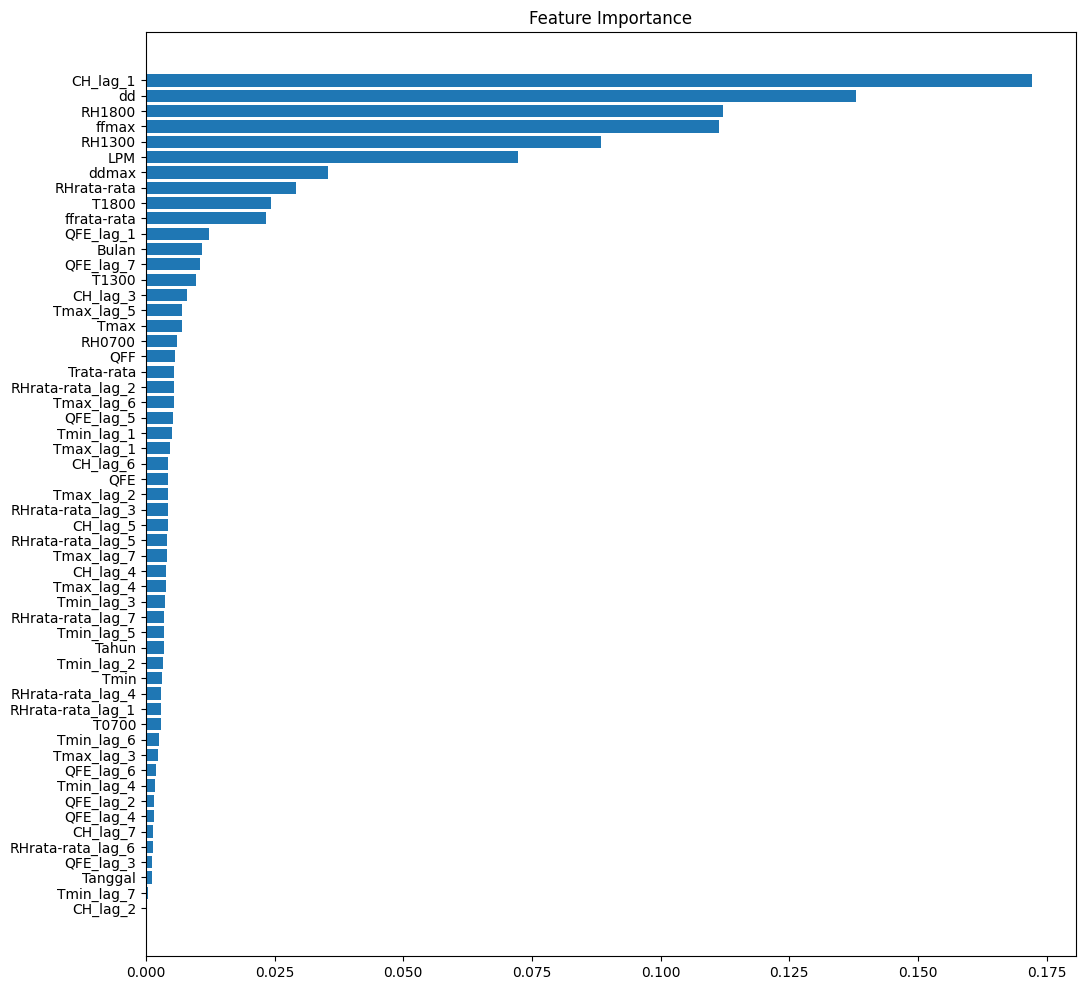

In [9]:
# Plot the feature importances using seaborn
# Arrange the plot so that it easy to read and have aesthetic visualisation
import matplotlib.pyplot as plt

sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 12))
plt.subplot(1, 1, 1)
plt.barh(pos, features_df['Importance'][sorted_idx], align='center')
plt.yticks(pos, features_df['Feature'][sorted_idx])
plt.title('Feature Importance')
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Select top features
sorted_idx = np.argsort(feature_importances)
top_features = np.array(X.columns)[sorted_idx][-5:]

# Select only the top features from the dataset
X_top_features = X[top_features]

# Splitting the dataset into train (64%), validation (16%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_top_features, y, test_size=0.2, random_state=111)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=111)

# Defining the XGBoost regressor with specified hyperparameters
xgb_model = XGBRegressor(
    tree_method='hist',
    n_estimators=2200,
    learning_rate=0.01,
    seed=123,
    # max_depth=20,
    booster='gbtree',
    # alpha=0.5,
    # reg_lambda=0.5,
    # min_child_weight=100,
    # subsample=0.5,
    # sampling_method='uniform',
    # colsample_bytree=0.5,
    # random_state=111,
    objective='reg:squarederror',
    early_stopping_rounds=50,
)

# Training the XGBoost model
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predicting on the test set
y_pred = xgb_model.predict(X_test)

# Calculating MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('MAE: {:.4f}'.format(mae))
print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))


MAE: 0.9323
MSE: 1.5842
RMSE: 1.2587


In [15]:
top_features

array(['RH1300', 'ffmax', 'RH1800', 'dd', 'CH_lag_1'], dtype=object)

In [17]:
import lightgbm as lgb

def lightgbm_model():
	hyper_params = {"task": "train",
					"boosting_type": "gbdt",
					"objective": "regression",
					"metric": ["l1", "l2"],
					# "learning_rate": 0.01,
					# "feature_fraction": 0.9,
					# "bagging_fraction": 0.7,
					# "bagging_freq": 10,
					# "verbose": 0,
					# "max_depth": 8,
					# "num_leaves": 128,  
					# "max_bin": 512,
					# "num_iterations": 100000
	}
	model = lgb.LGBMRegressor(**hyper_params)
	return model

def train_lightgbm(X_train, y_train, X_val, y_val, X_test):
	model = lightgbm_model()
	model.fit(X_train, 
			  y_train,
			  eval_set=[(X_val, y_val)],
			  eval_metric='l2'
	)
	predictions = model.predict(X_test)
	# evaluation = [mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions)]
	# print(evaluation)
	# st.write(evaluation)
	return model, predictions

model, y_pred = train_lightgbm(X_train, y_train, X_val, y_val, X_test)

# Calculating MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('MAE: {:.4f}'.format(mae))
print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 2595, number of used features: 5
[LightGBM] [Info] Start training from score 1.195645
MAE: 0.9292
MSE: 1.9064
RMSE: 1.3807


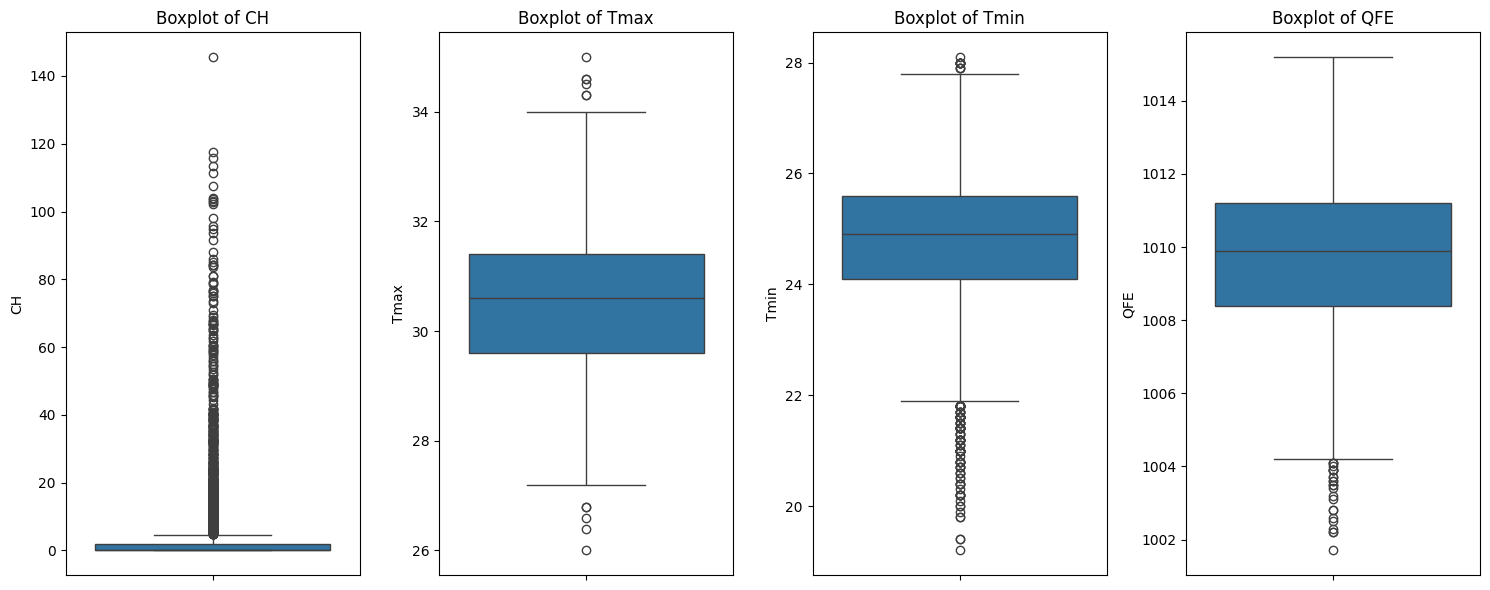

In [18]:
# Re-loading the original dataset to visualize outliers
original_data = pd.read_csv(os.path.join(dir, filename), parse_dates=['Date'], index_col='Date')

# Columns to visualize for outliers
columns_to_visualize = ['CH', 'Tmax', 'Tmin', 'QFE']

# Plotting boxplots for each column
plt.figure(figsize=(15, 6))
for i, col in enumerate(columns_to_visualize, 1):
    plt.subplot(1, len(columns_to_visualize), i)
    sns.boxplot(y=original_data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [21]:
# Create a cross validation mechanism before training the model
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

# Create a dataframe to store the results of each fold
results_df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE'])

# Create a dataframe to store the predictions of each fold
predictions_df = pd.DataFrame()

# Create a dataframe to store the feature importances of each fold
feature_importances_df = pd.DataFrame()

# Create a dataframe to store the actual values of each fold
actual_values_df = pd.DataFrame()

# Run the cross validation using the TimeSeriesSplit object with XGBoost
for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
	# Splitting the dataset into train and validation sets
	X_train, X_val = X.iloc[train_index], X.iloc[val_index]
	y_train, y_val = y.iloc[train_index], y.iloc[val_index]

	# Defining the XGBoost regressor with specified hyperparameters
	xgb_model = XGBRegressor(
		tree_method='hist',
		n_estimators=2200,
		learning_rate=0.01,
		seed=123,
		# max_depth=20,
		booster='gbtree',
		# alpha=0.5,
		# reg_lambda=0.5,
		# min_child_weight=100,
		# subsample=0.5,
		# sampling_method='uniform',
		# colsample_bytree=0.5,
		# random_state=111,
		objective='reg:squarederror',
		early_stopping_rounds=50,
	)

	# Training the XGBoost model
	xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

	# Predicting on the validation set
	y_pred = xgb_model.predict(X_val)

	# Calculating MAE, MSE, and RMSE
	mae = mean_absolute_error(y_val, y_pred)
	mse = mean_squared_error(y_val, y_pred)
	rmse = np.sqrt(mse)

	# Storing the results of each fold to the results dataframe	
	new_row = pd.Series({'MAE': mae, 'MSE': mse, 'RMSE': rmse})
	new_row_df = new_row.to_frame().T
	new_row_df = new_row_df.dropna(axis=1, how='all')
	results_df = pd.concat([results_df, new_row_df], ignore_index=True)
	
	# results_df = results_df.append({'MAE': mae, 'MSE': mse, 'RMSE': rmse}, ignore_index=True)

	# Storing the predictions of each fold to the predictions dataframe
	predictions_df = pd.concat([predictions_df, pd.DataFrame(y_pred)], axis=1)

	# Storing the feature importances of each fold to the feature importances dataframe
	feature_importances_df = pd.concat([feature_importances_df, pd.DataFrame(xgb_model.feature_importances_)], axis=1)

	# Storing the actual values of each fold to the actual values dataframe
	actual_values_df = pd.concat([actual_values_df, pd.DataFrame(y_val)], axis=1)

# Rename the columns of the predictions dataframe
predictions_df.columns = ['Fold {}'.format(fold) for fold in range(1, predictions_df.shape[1] + 1)]

# Rename the columns of the feature importances dataframe
feature_importances_df.columns = ['Fold {}'.format(fold) for fold in range(1, feature_importances_df.shape[1] + 1)]

# Rename the columns of the actual values dataframe
actual_values_df.columns = ['Fold {}'.format(fold) for fold in range(1, actual_values_df.shape[1] + 1)]

# Create a dataframe to store the mean of the results of each fold
mean_results_df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE'])

# Calculate the mean of the results of each fold
mean_results_df.loc[0, :] = results_df.mean()

# Create a dataframe to store the standard deviation of the results of each fold
std_results_df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE'])

# Calculate the standard deviation of the results of each fold
std_results_df.loc[0, :] = results_df.std()

# Print the results of each fold
print("Each fold's results:")
print(results_df)

# Print the mean of the results of each fold
print("Mean of each fold's results:")
print(mean_results_df)

# Print the standard deviation of the results of each fold
print("Standard deviation of each fold's results:")
print(std_results_df)

# Create a dataframe to store the mean of the feature importances of each fold
mean_feature_importances_df = pd.DataFrame(columns=['Importance'])

# Calculate the mean of the feature importances of each fold
mean_feature_importances_df.loc[:, 'Importance'] = feature_importances_df.mean(axis=1)

# Create a dataframe to store the standard deviation of the feature importances of each fold
std_feature_importances_df = pd.DataFrame(columns=['Importance'])

# Calculate the standard deviation of the feature importances of each fold
std_feature_importances_df.loc[:, 'Importance'] = feature_importances_df.std(axis=1)

# Print the feature importances of each fold
print("Feature importances of each fold:")
print(feature_importances_df)

# Print the mean of the feature importances of each fold
print("Mean of each fold's feature importances:")
print(mean_feature_importances_df)

# Print the standard deviation of the feature importances of each fold
print("Standard deviation of each fold's feature importances:")
print(std_feature_importances_df)

# Create a dataframe to store the mean of the actual values of each fold
mean_actual_values_df = pd.DataFrame(columns=['Actual Values'])

# Calculate the mean of the actual values of each fold
mean_actual_values_df.loc[:, 'Actual Values'] = actual_values_df.mean(axis=1)

# Create a dataframe to store the standard deviation of the actual values of each fold
std_actual_values_df = pd.DataFrame(columns=['Actual Values'])

# Calculate the standard deviation of the actual values of each fold
std_actual_values_df.loc[:, 'Actual Values'] = actual_values_df.std(axis=1)

# Print the actual values of each fold
print("Actual values of each fold:")
print(actual_values_df)

# Print the mean of the actual values of each fold
print("Mean of each fold's actual values:")
print(mean_actual_values_df)

# Print the standard deviation of the actual values of each fold
print("Standard deviation of each fold's actual values:")
print(std_actual_values_df)

# Create a dataframe to store the mean of the predictions of each fold
mean_predictions_df = pd.DataFrame(columns=['Predictions'])

# Calculate the mean of the predictions of each fold
mean_predictions_df.loc[:, 'Predictions'] = predictions_df.mean(axis=1)

# Create a dataframe to store the standard deviation of the predictions of each fold
std_predictions_df = pd.DataFrame(columns=['Predictions'])

# Calculate the standard deviation of the predictions of each fold
std_predictions_df.loc[:, 'Predictions'] = predictions_df.std(axis=1)

# Print the predictions of each fold
print("Predictions of each fold:")
print(predictions_df)

/var/folders/32/vh33lqk957b190j6lf1vrvy80000gn/T/ipykernel_13480/1224612147.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row_df], ignore_index=True)


Each fold's results:
        MAE       MSE      RMSE
0  1.005110  2.029277  1.424527
1  1.006550  2.126909  1.458392
2  1.230648  2.890811  1.700238
3  1.126211  2.224363  1.491430
4  1.032107  2.304002  1.517894
Mean of each fold's results:
        MAE       MSE      RMSE
0  1.080125  2.315072  1.518496
Standard deviation of each fold's results:
        MAE       MSE      RMSE
0  0.097631  0.337976  0.107478
Feature importances of each fold:
      Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
0   0.002032  0.003980  0.002046  0.003405  0.002515
1   0.006292  0.007296  0.007892  0.004660  0.008557
2   0.004478  0.004680  0.006292  0.005984  0.007236
3   0.005160  0.005571  0.009928  0.008191  0.008653
4   0.005107  0.007623  0.007511  0.008547  0.010407
5   0.015995  0.014994  0.011312  0.009773  0.012200
6   0.023840  0.012323  0.027594  0.016830  0.013619
7   0.021044  0.017048  0.014102  0.024803  0.015593
8   0.006501  0.010782  0.014391  0.012684  0.011930
9   0.014274  0.035690 

In [23]:
new_row_df.isna().sum

<bound method DataFrame.sum of      MAE    MSE   RMSE
0  False  False  False>